# Erstellung eines ARIMA-Modells
## zur Vorhersage des Energieverbrauchs

In [45]:
!pip install pmdarima

In [46]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

plt.style.use('ggplot')

print("Setup complete")

Setup complete


In [47]:
def print_metrics(actual, predicted):
    """
    Berechnet MAE, RMSE und MAPE zwischen den tatsächlichen und vorhergesagten Werten.
    :param actual: Array der tatsächlichen Werte
    :param predicted: Array der vorhergesagten Werte
    """
    actual, predicted = np.array(actual), np.array(predicted)

    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = mean_absolute_percentage_error(actual, predicted) * 100

    print(f"MAE: {round(mae, 2)}, RMSE: {round(rmse, 2)}, MAPE: {round(mape, 2)} %")

In [48]:
df = pd.read_csv("../input/2024-01-05-2/austin10_hourly.csv")
df = df[df.dataid == 661][['timestamp', 'use']]
df.set_index('timestamp', inplace=True)

df.head()

,use
timestamp,
2018-01-01 07:00:00,1.54425
2018-01-01 08:00:00,1.10400
2018-01-01 09:00:00,0.96300
2018-01-01 10:00:00,0.76625
2018-01-01 11:00:00,0.75875


## ARIMA Modellparameter manuell entwickeln

Tutorial: https://www.kaggle.com/code/kanncaa1/time-series-prediction-tutorial-with-eda

Wenn dauerhaft eine Leistung von 1,6 kW gemessen wird und diese Leistung über eine ganze Stunde konstant bleibt, dann ist der Gesamtverbrauch pro Stunde einfach zu berechnen. Die Einheit Kilowatt (kW) ist eine Maßeinheit für die Leistung, und Kilowattstunden (kWh) sind eine Maßeinheit für die Energie, die angibt, wie viel Energie verbraucht wird, wenn eine bestimmte Leistung über eine bestimmte Zeit aufrechterhalten wird.

Die Formel zur Berechnung des Energieverbrauchs ist:

> Energie (kWh) = Leistung (kW) * Zeit (Stunden)

In Ihrem Fall, wenn eine Leistung von 1,6 kW über eine Stunde aufrechterhalten wird, dann ist der Energieverbrauch:

> Energie = 1,6 kW  * 1 Stunde = 1,6 kWh

Daher beträgt der Gesamtenergieverbrauch 1,6 kWh pro Stunde, wenn die Leistung von 1,6 kW kontinuierlich über die gesamte Stunde aufrechterhalten wird.

### Dickey-Fuller-Test: ERGEBNISSE NICHT WIE ERWARTET
* https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
* https://stackoverflow.com/questions/47349422/how-to-interpret-adfuller-test-results

In [49]:
result = adfuller(df.use)

test_statistic = result[0]
crit_values = result[4]
max_crit_value = max(crit_values.values())

print("Test statistic: ", test_statistic)
print("Critical Values: ", crit_values)
print()

if test_statistic > max_crit_value:
    print(f"Test statistic is bigger than the critical values: {round(test_statistic, 2)} > {round(max_crit_value, 2)}")
    print("Null hypothesis can't be rejected")
    print("Time series is non stationary")
else:
    print("Test statistic is smaller than the 1% critical values so we can say with 99% confidence that this is a stationary series")
    print("Time series is stationary")

Test statistic:  -6.220348141667479
Critical Values:  {'1%': -3.4310806943814685, '5%': -2.8618629192880443, '10%': -2.566941884917854}

Test statistic is smaller than the 1% critical values so we can say with 99% confidence that this is a stationary series
Time series is stationary


## Auto-ARIMA-Modell
### Setting m: https://alkaline-ml.com/pmdarima/tips_and_tricks.html#setting-m
Blog post: https://robjhyndman.com/hyndsight/seasonal-periods/
1. Saisonalitätsannahme: Der Wert m gibt die Länge der saisonalen Periode an. Bei m=24 geht das Modell davon aus, dass sich das Muster Ihrer Zeitreihe alle 24 Stunden wiederholt. Dies ist typisch für stündliche Daten, bei denen Sie tägliche Muster erwarten, wie z.B. höhere Aktivität während des Tages und niedrigere Aktivität in der Nacht.
2. Saisonale Differenzierung: Im Kontext von ARIMA-Modellen (und deren Erweiterungen wie SARIMA oder AutoARIMA) bezieht sich die saisonale Differenzierung auf die Anzahl der Differenzierungen, die erforderlich sind, um die saisonale Komponente der Zeitreihe stationär zu machen. Bei m=24 wird AutoARIMA versuchen, saisonale Effekte zu erkennen und zu modellieren, die sich im 24-Stunden-Rhythmus wiederholen.
3. Anwendungsbereiche: Ein solches Modell wäre beispielsweise sinnvoll bei der Analyse von Verkehrsdaten, Energieverbrauch, Webseitenaufrufen oder anderen stündlichen Messungen, bei denen tägliche Schwankungen eine Rolle spielen.
4. Modellierungskomplexität: Die Einbeziehung einer täglichen Saisonalität (m=24) in stündlichen Daten kann die Komplexität des Modells erhöhen. Es ist wichtig, die Modellpassung und -vorhersagen sorgfältig zu überprüfen, um sicherzustellen, dass das Modell die saisonalen Muster angemessen erfasst und nicht über- oder unterangepasst ist.

In [52]:
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

In [53]:
auto_model = auto_arima(train_data) # m=24
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7187
Model:               SARIMAX(2, 1, 5)   Log Likelihood               -8178.076
Date:                Sat, 06 Jan 2024   AIC                          16374.151
Time:                        15:18:10   BIC                          16436.070
Sample:                             0   HQIC                         16395.460
                               - 7187                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.623e-05      0.000      0.101      0.919      -0.000       0.001
ar.L1         -0.1628      0.490     -0.332      0.740      -1.123       0.797
ar.L2          0.5740      0.347      1.654      0.098      -0.106       1.254
ma.L1         -0.1343      0.491     -0.274      0.784      -1.096       0.827
ma.L2         -0.8414      0.492     -1.712      0.087      -1.805       0.122
ma.L3          0.0057      0.020      0.293      0.769      -0.033       0.044
ma.L4          0.0067      0.021      0.321      0.748      -0.034       0.048
ma.L5         -0.0157      0.018     -0.892      0.372      -0.050       0.019
sigma2         0.5751      0.007     83.883      0.000       0.562       0.589
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             10128.87
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.20   Skew:                             1.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [54]:
predictions = auto_model.predict(n_periods=len(test_data))
print_metrics(test_data, predictions)

MAE: 0.76, RMSE: 0.95, MAPE: 99.87 %


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [55]:
df_comp = pd.DataFrame(test_data)
df_comp.reset_index(inplace=True)
df_comp.timestamp = pd.to_datetime(df_comp.timestamp)
df_comp.rename(columns={'use': 'actual'}, inplace=True)
df_comp['predicted'] = predictions.values
df_comp.head(5)

,timestamp,actual,predicted
0,2018-10-18 09:00:00,3.86200,1.636290
1,2018-10-18 10:00:00,2.14725,1.515786
2,2018-10-18 11:00:00,0.62275,1.455592
3,2018-10-18 12:00:00,0.71150,1.406407
4,2018-10-18 13:00:00,0.72875,1.364056


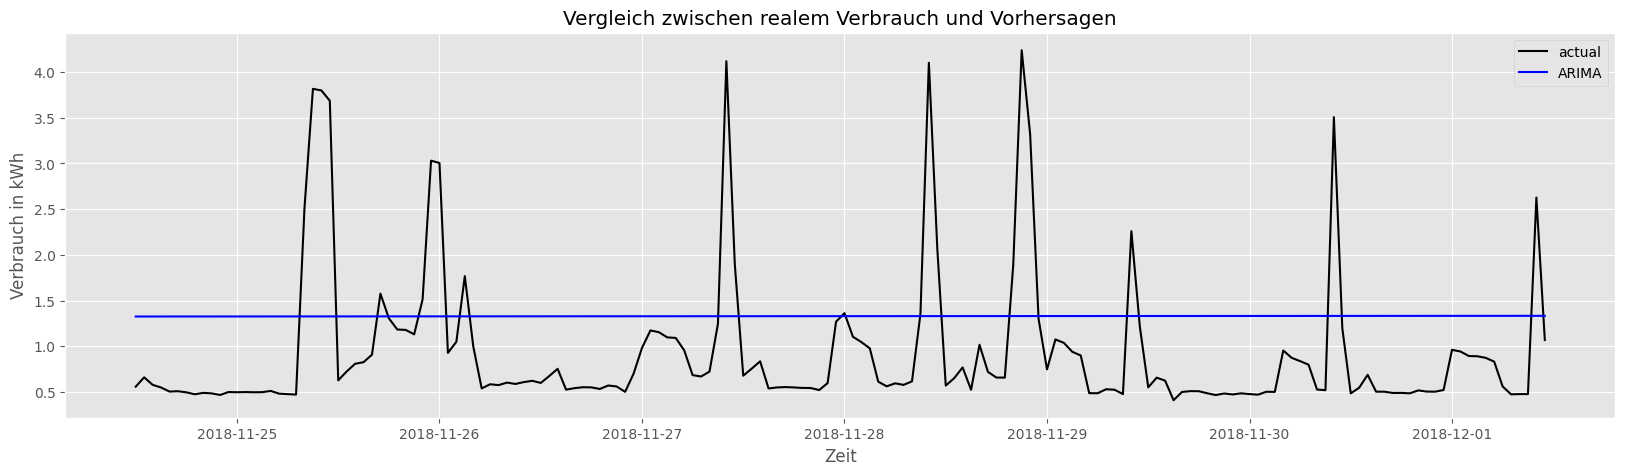

In [56]:
datapoints_week = 24 * 7
last_start_idx = len(df_comp) - datapoints_week - 1
start_idx = random.randint(0, last_start_idx)
end_idx = start_idx + 24 * 7
df_plot = df_comp[start_idx:end_idx]

plt.figure(figsize=(20, 5))
plt.plot(df_plot.timestamp, df_plot.actual, color='black', label='actual')
plt.plot(df_plot.timestamp, df_plot.predicted, color='blue', label='ARIMA')
plt.title('Vergleich zwischen realem Verbrauch und Vorhersagen')
plt.xlabel('Zeit')
plt.ylabel('Verbrauch in kWh')
plt.legend()
plt.show()

In [ ]:
# model = ARIMA(train_data, order=auto_model.order)
# model_fit = model.fit()

# forecast = model_fit.forecast(steps=len(test_data))
# print_metrics(test_data, forecast)

In [ ]:
# df_comp = pd.DataFrame(test_data)
# df_comp.reset_index(inplace=True)
# df_comp.timestamp = pd.to_datetime(df_comp.timestamp)
# df_comp.rename(columns={'use': 'actual'}, inplace=True)
# df_comp['predicted'] = forecast.values
# df_comp.head(5)

In [ ]:
# df_plot3 = df_comp.copy()
# df_plot3.set_index('timestamp', inplace=True)
# df_plot3.actual_value.resample('H').mean()

# first_7_days = 24 * 7
# df_first_7_days = df_plot3[split_idx:split_idx+first_7_days]

# plt.figure(figsize=(20, 5))
# plt.plot(df_first_7_days.index, df_first_7_days.actual_value, color='black', label='actual')
# plt.plot(df_first_7_days.index, df_first_7_days.predicted_value, color='blue', label='predicted')
# plt.title('Vergleich zwischen realem Verbrauch und Vorhersage (stündlich aggregiert)')
# plt.xlabel('Monat')
# plt.ylabel('Verbrauch in kWh')
# plt.legend()
# plt.show()

## Probleme und To-do
* Dickey-Fuller-Test liefern nicht das erwartete Ergebnis
* Warum funktioniert Auto-ARIMA-Modell nicht
* Warum funktioniert forecast-Funktion bein ARIMA-Modell nicht, sondern nur predict
* Ist es problematisch, dass alle Daten zum Trainieren verwendet werden --> Ja --> Was dagegen tun?
* Overfitting?!
* https://www.kaggle.com/learn/time-series